# Week 7, Lab \#6

*February 28, 2024*

In today's lab, we'll get some practice using the `rasterio` module and apply what we learned about focal operations to identify **changing lake levels in Kicking Horse Reservoir** over a 12-year period. Kicking Horse Reservoir is located on the lands of the Confederated Salish and Kootenai Tribes (CSKT) in Montana, just north of Missoula, in the Flathead Valley. **As part of this lab we'll introduce two new Python modules:**

- `fiona`: For reading and writing vector data like ESRI Shapefiles
- `shapely`: For representing vector features like Polygons, MultiPolygons, Lines, and Points

**We're interested in quantifying the area of the reservoir in two years: 1999 and 2011.** We might use these areas combined with a bathymetry map to calculate total reservoir water storage, for example. We could generate a time series of such estimates, once a month or once a year, to monitor change in water resources.

[We'll be using data from the Landsat 5 satellite.](https://www.usgs.gov/landsat-missions/landsat-5) Landsat 5 carried the Thematic Mapper (TM) instrument, which measures reflected light from the Earth's surface at visible, near-infrared (NIR), and short-wave infrared (SWIR) wavelengths. I downloaded four GeoTIFFs, two images for each date:

- August 27, 1999 (19990827)
- August 28, 2011 (20110828)

I downloaded Bands 2 and 4 for each date; Band 2 is the Green band and Band 4 is the first NIR band. The Green and NIR bands can be used to calculate the Normalized Difference Water Index (NDWI), a measure of where open water occurs in an image.

[**You can read more about Landsat data here.**](https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products)

**We'll start with loading some of the packages we'll need to use for this lab.**

In [2]:
import fiona
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

Remember, if you get an `ImportError` because you haven't installed a package, you can do so from the Command Line/ PowerShell, e.g., for the `fiona` package:

```sh
pip install fiona
```

### Troubleshooting

Depending on your setup, you may run into some version issues with `fiona` or an `ImportError` when trying to import `shapely`. The first thing to try would be to start Jupter Notebook **using the OSGeo4W Shell, as described in the Syllabus, and not the "Jupyter Notebook" shortcut:**

```sh
cd C:/Users/username
python -m notebook
```

Where `username` is your actual username.

### Download the Data

**First, [download the four GeoTIFFs from this link](http://files.ntsg.umt.edu/data/GIS_Programming/data/LT05_Charlo_lake.zip), unzip the archive, and put them in a `data` directory accessible by this notebook; for example:**

In [3]:
ds_tm99_green = rio.open('data/LT05_L2SP_041027_19990827_20200907_02_T1_SR_B2.TIF')
ds_tm99_nir   = rio.open('data/LT05_L2SP_041027_19990827_20200907_02_T1_SR_B4.TIF')
ds_tm11_green = rio.open('data/LT05_L2SP_041027_20110828_20200820_02_T1_SR_B2.TIF')
ds_tm11_nir   = rio.open('data/LT05_L2SP_041027_20110828_20200820_02_T1_SR_B4.TIF')

In [5]:
ds_tm99_green

<open DatasetReader name='data/LT05_L2SP_041027_19990827_20200907_02_T1_SR_B2.TIF' mode='r'>

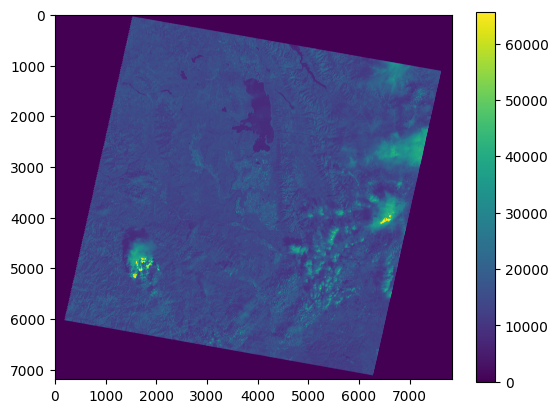

In [5]:
plt.imshow(ds_tm99_nir.read(1))
plt.colorbar()

Those data values (on the color bar) don't look right... We have surface reflectance data so the values should be between 0 and 1: surface reflectance is the ratio of reflected light to total incoming light.

**To save disk space, these Landsat data products are stored as unsigned 16-bit integers, where the reflectance values were converted from floating point to a large integer.** Consequently, the data must be **re-scaled** to obtain meaningful units (surface reflectance).

[**I encourage you to read this short article so as to understand re-scaling of Landsat data.**](https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products)

We can also verify the data values don't match our expectations by looking at percentiles of the data:

In [6]:
np.percentile(ds_tm99_nir.read(1), (0, 50, 100))

array([    0., 13218., 65535.])

We need to rescale the data before we can do any analysis (e.g., calculating NDWI). However, we also need to spatially subset the data to our area of interest. **Going forward, we should make sure that we always do things in the right order, the "Python Geoprocessing Order of Operations:"**

1. Conduct of all our spatial operations first, while the data are represented as a `rasterio.DatasetReader` or a `gdal.Dataset`.
2. Then, extract the data as an array to perform any numerical operations.

It's necessary to do things in this order because most spatial functions can't work with `numpy.ndarray`, as arrays don't preserve any spatial information. Consequently, for this exercise, we must clip the data first, then re-scale it.

## Cropping to an Area of Interest

So, the first spatial operation we want to conduct is to crop the data to our area of interest around Kicking Horse Reservoir. 

**We'll use the `fiona` library to open a Shapefile that represents our area of interest.** `fiona` is similar to `rasterio` except that `fiona` works with vector datasets like Shapefiles instead of raster data.

In [7]:
import geopandas as gpd

aoi = fiona.open('data/Charlo_lake_mask_boundary.shp')
type(aoi)

fiona.collection.Collection

In [8]:
# Geopandas version
aoi2 = gpd.read_file('data/Charlo_lake_mask_boundary.shp')
type(aoi2)

geopandas.geodataframe.GeoDataFrame

When we read in a vector dataset, it comes in as a Geometry Collection. You can think of this as a Python sequence; i.e., we can index the sequence to get the first vector feature (e.g., first polygon). The representation of the vector feature, shown below, is called GeoJSON and we'll talk more about it later in the course.

In [9]:
# Geopandas version
aoi2

,MINX,MINY,MAXX,MAXY,CNTX,CNTY,AREA,PERIM,HEIGHT,WIDTH,geometry
0,694750.148653,5.243350e+06,741644.34142,5.274096e+06,718197.245036,5.258723e+06,1.441811e+09,155280.495055,30746.054761,46894.192766,"POLYGON ((694750.149 5243349.903, 694750.149 5..."


In [10]:
fiona.model.to_dict(aoi[0])

{'geometry': {'coordinates': [[(694750.1486531997, 5243349.902534474),
    (694750.1486531997, 5274095.957295853),
    (741644.3414195041, 5274095.957295853),
    (741644.3414195041, 5243349.902534474),
    (694750.1486531997, 5243349.902534474)]],
  'type': 'Polygon'},
 'id': '0',
 'properties': {'MINX': 694750.1486531997,
  'MINY': 5243349.902534474,
  'MAXX': 741644.3414195041,
  'MAXY': 5274095.957295853,
  'CNTX': 718197.245036352,
  'CNTY': 5258722.929915164,
  'AREA': 1441811418.7834616,
  'PERIM': 155280.495055367,
  'HEIGHT': 30746.054761379026,
  'WIDTH': 46894.19276630448},
 'type': 'Feature'}

It's kind of hard to read all bunched-up like that, so we can use the built-in `json` library to better display our GeoJSON:

In [11]:
import json

print(json.dumps(fiona.model.to_dict(aoi[0]), indent = 2))

{
  "geometry": {
    "coordinates": [
      [
        [
          694750.1486531997,
          5243349.902534474
        ],
        [
          694750.1486531997,
          5274095.957295853
        ],
        [
          741644.3414195041,
          5274095.957295853
        ],
        [
          741644.3414195041,
          5243349.902534474
        ],
        [
          694750.1486531997,
          5243349.902534474
        ]
      ]
    ],
    "type": "Polygon"
  },
  "id": "0",
  "properties": {
    "MINX": 694750.1486531997,
    "MINY": 5243349.902534474,
    "MAXX": 741644.3414195041,
    "MAXY": 5274095.957295853,
    "CNTX": 718197.245036352,
    "CNTY": 5258722.929915164,
    "AREA": 1441811418.7834616,
    "PERIM": 155280.495055367,
    "HEIGHT": 30746.054761379026,
    "WIDTH": 46894.19276630448
  },
  "type": "Feature"
}


In this case, we have a simple bounding box and it is the only feature in the dataset; hence:

In [12]:
len(aoi)

1

Inside the GeoJSON feature is a dictionary-like object; we're interested in the `"geometry"` key because this describes the shape of our bounding box (a rectangle):

In [13]:
# Geopandas version
print(aoi2['geometry'])

0    POLYGON ((694750.149 5243349.903, 694750.149 5...
Name: geometry, dtype: geometry


In [14]:
print(fiona.model.to_dict(aoi[0])['geometry'])

{'coordinates': [[(694750.1486531997, 5243349.902534474), (694750.1486531997, 5274095.957295853), (741644.3414195041, 5274095.957295853), (741644.3414195041, 5243349.902534474), (694750.1486531997, 5243349.902534474)]], 'type': 'Polygon'}


**We'll use the shapely library to convert what is essentially a dictionary (above) into a shape representation that can be used with `fiona` and `rasterio`.**

In [15]:
from shapely import geometry

bbox = geometry.shape(fiona.model.to_dict(aoi[0])['geometry'])

The `rasterio` module includes a `mask` sub-module that contains functionality for cropping raster data. In this Lab, we'll use the `mask()` function to clip the Landsat image to our area of interest:

In [16]:
from rasterio.mask import mask

mask(ds_tm11_nir, bbox, crop = True)

TypeError: 'Polygon' object is not iterable

**Whoops! I included this error because we need more practice reading Python Tracebacks.** As indicated above, `Polygon` objects are not *iterable,* i.e., they can't be indexed like a Python `list` or `tuple`. This is an indication that the `mask()` function is expecting the second argument to be a sequence. We could have learned this from reading the help documentation:

```py
help(mask)
```

But we can also fix our mistake by putting `bbox` inside a `list`, which is a type of sequence:

In [17]:
result = mask(ds_tm11_nir, [bbox], crop = True)
result

(array([[[    0, 14217, 13770, ..., 13132, 12839, 13278],
         [    0, 14068, 13622, ..., 13132, 13425, 13718],
         [    0, 13771, 13623, ..., 13425, 14011, 14011],
         ...,
         [    0, 13714, 13712, ..., 14327, 14769, 15799],
         [    0, 13713, 13711, ..., 15651, 16094, 16534],
         [    0,     0,     0, ...,     0,     0,     0]]], dtype=uint16),
 Affine(30.0, 0.0, 694725.0,
        0.0, -30.0, 5274105.0))

**As another example of our Python Geoprocessing Order of Operations, we can see that the `mask()` function actually returns a tuple of two elements.** Remember that anytime a Python expression on the right-hand side evaluates to a sequence of elements, we can "unpack" each element in the sequence, assigning it to a different variable name, in order:

```py
array, transform = mask(dataset, [bbox], crop = True)
```

In this example, `array` is just a `numpy.ndarray` and `transform` is actually an instance of an `affine.Affine` transformation. Together, along with knowledge of the original projection (e.g., a `wkt` string), we can re-assemble the spatial dataset! But until then, we now have a `numpy.ndarray` to work with.

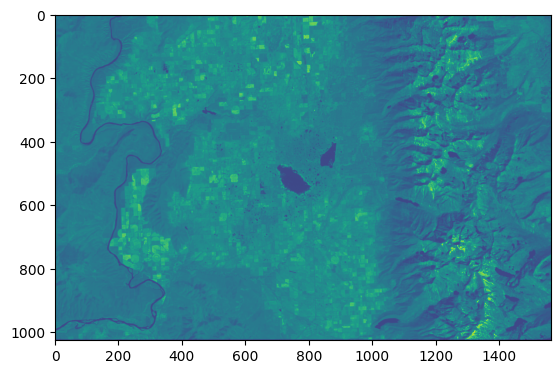

In [18]:
tm11_nir_sub, transform = mask(ds_tm11_nir, [bbox], crop = True)
plt.imshow(tm11_nir_sub[0])

In the 2011 image, Kicking Horse Reservoir is the second-largest lake, to the north-east of the largest lake.

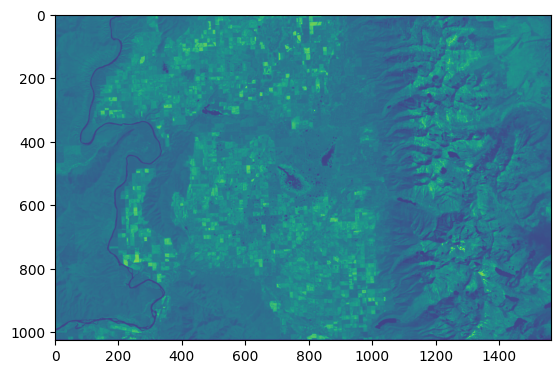

In [19]:
tm99_nir_sub, transform = mask(ds_tm99_nir, [bbox], crop = True)
plt.imshow(tm99_nir_sub[0])

**Now we're ready to transform and analyze the data!**

---

## Problem 6.1: Raster Data Pre-Processing

Write a Python function (using `def` keyword) called `mask_and_rescale()` that:

1. Accepts a `rasterio` dataset as an argument
2. Crops the data to our region of interest
3. Applies the scale factor to convert the data to surface reflectance units
4. Ensures that all values lie on the closed interval $[0,1]$
5. Returns a `numpy.ndarray`

**For Item \#4,** data values below zero should be set to zero (0.0) and values above one should be set to one (1.0). Note that these single-band datasets from Landsat don't have NoData values set (-9999 is the Fill Value but it doesn't appear inside the raster array). For now, that's not a problem as we'll be working with a small subset of the data.

As an example of rescaling (Step 3), [recall from the Landsat documentation on scale factors](https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products) that we can recover the surface reflectance value by:

In [20]:
unscaled_value = 10000
unscaled_value * 0.0000275 + -0.2

0.07500000000000001

When you've written the `mask_and_rescale()` function correctly, the following code block should run without error.

In [21]:
def mask_and_rescale(data):
    # Crop data to aoi
    arr, transform = mask(data, [bbox], crop = True)
    # Convert to surface reflectance
    arr_scaled = np.array(arr) * 0.0000275 + -0.2
    # If converted values are below 0.0, set to 0.0, else continue
    arr_scaled[arr_scaled < 0.0] = 0
    # If converted values are above 1.0, set to 1.0, else continue
    arr_scaled[arr_scaled > 1.0] = 1
    # Save the result as a np.ndarray
    return arr_scaled

[[[0.        0.0926825 0.0970275 ... 0.0355925 0.03562   0.0399925]
  [0.        0.0926825 0.0970275 ... 0.0355925 0.0355925 0.03562  ]
  [0.        0.0926825 0.0970275 ... 0.048655  0.0486825 0.0399375]
  ...
  [0.        0.087045  0.0914725 ... 0.0717    0.0716725 0.084735 ]
  [0.        0.087045  0.0914725 ... 0.08039   0.084735  0.084735 ]
  [0.        0.        0.        ... 0.        0.        0.       ]]]


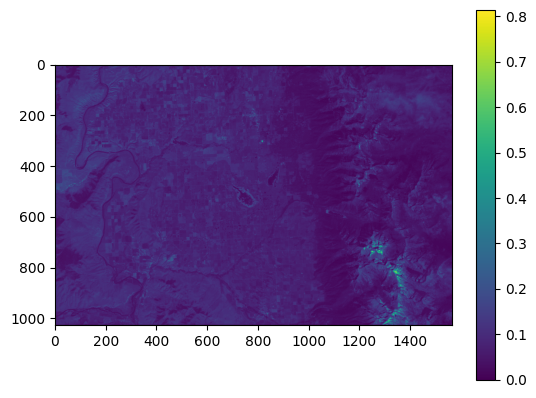

In [22]:
test = mask_and_rescale(ds_tm99_green)
print(test)
plt.imshow(test[0])
plt.colorbar()

In [23]:
tm99_green = mask_and_rescale(ds_tm99_green)
tm11_green = mask_and_rescale(ds_tm11_green)
tm99_nir = mask_and_rescale(ds_tm99_nir)
tm11_nir = mask_and_rescale(ds_tm11_nir)
assert type(tm99_green) is np.ndarray
assert tm99_green.shape == (1, 1026, 1564)
assert tm99_green.min() >= 0
assert tm99_green.max() <= 1

---

**Now we're ready to calculate the NDWI.**

---

## Problem 6.2: Calculate NDWI

Write a Python function that calculates the NDWI. 

$$
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}
$$

**Note:** You may get a `RuntimeWarning` when you've written and called the function (correctly). This is because there are some pixels that have a combined Green + NIR reflectance equal to zero, so there is a divide-by-zero error for those pixels. We can't do anything about that, and we don't really care about those pixels, so this `RuntimeWarning` can be safely ignored.

Apply the function, and call the output arrays `tm99_ndwi` and `tm11_ndwi` for the 1999 and 2011 NDWI images, respectively, as below.

In [24]:
def ndwi(green, nir):
    ndwi = (green - nir)/(green + nir)
    return ndwi

In [25]:
tm99_ndwi = ndwi(tm99_green, tm99_nir)
tm11_ndwi = ndwi(tm11_green, tm11_nir)

C:\Users\by197116\AppData\Local\Temp\ipykernel_23632\2133730512.py:2: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir)/(green + nir)


---

**Plotting the NDWI images, we can see that water-filled areas are now especially visible.**

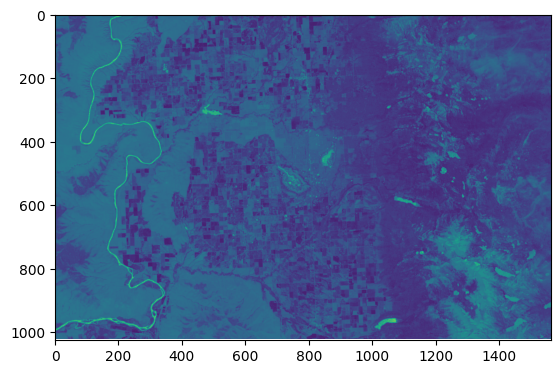

In [27]:
plt.imshow(tm99_ndwi[0])

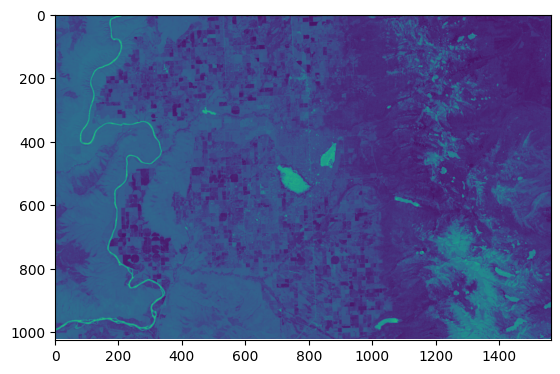

In [28]:
plt.imshow(tm11_ndwi[0])

**But what range of NDWI values represents water?** [McFeeters et al. (1996)](https://doi.org/10.1080/01431169608948714) suggested that open water will have positive NDWI values while all others will have negative NDWI values. We can use a remote sensing technique called *density slicing* to evaluate the hypothesis that positive NDWI indicates open water.

Density slicing simply refers to the masking of an image so that only values within a given range are shown.

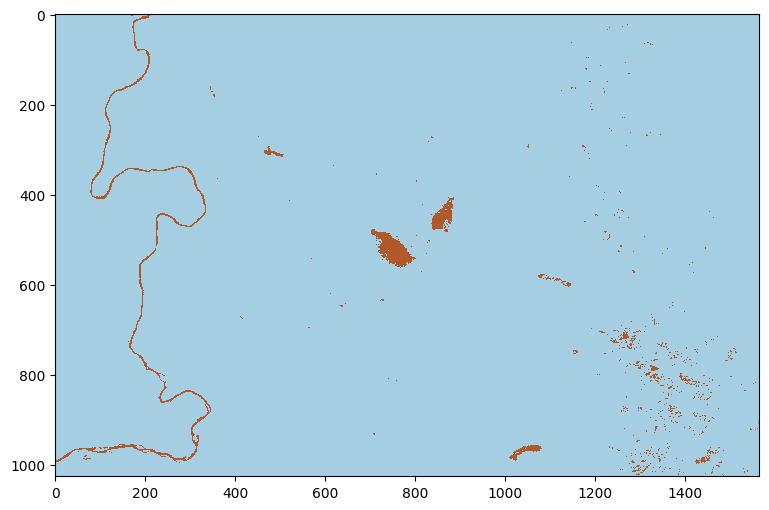

In [30]:
import matplotlib
cmap = matplotlib.colormaps.get('Paired')

# Return a 1 where NDWI > 0, 0 otherwise
water = np.where(tm11_ndwi[0] > 0, 1, 0)

plt.figure(figsize = (10, 6))
plt.imshow(water, cmap = cmap, interpolation = 'nearest')

There's obviously a lot of spurious water pixel detections... We can use *focal erosion* and *focal dilation* to clean up noisy classified images like this one.

Recall that *focal operations* are like a moving-window filter over the image and we can use `scipy.ndimage.generic_filter()` to achieve this effect.

In [31]:
from scipy.ndimage import generic_filter

The footprint of the moving window we want to use will be shaped like a cross, but let's exclude the center pixel.

In [32]:
cross = np.zeros((5,5))
cross[0,2] = 1
cross[1,1:4] = 1
cross[2,:] = 1
cross[3,1:4] = 1
cross[4,2] = 1
cross[2,2] = 0 # Don't count the center pixel
cross

array([[0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [1., 1., 0., 1., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

---

## Problem 6.3: Focal Dilation

Using `scipy.ndimage.generic_filter()` with the argument `footprint = cross` (where `cross` refers to the array from above), apply a moving window filter to the `water` array such that **if any pixel within the moving window is water, the target pixel is assigned water (1); otherwise, it is assigned non-water (0).**

The resulting array should be assigned the variable name `water2`.

**Hint:** There are a couple of different ways to test if our moving window (a NumPy array) "contains any water" pixels. Since water pixels have a value 1, we could just see if the sum or maximum is greater than zero:

In [34]:
import scipy.ndimage

def any1there(window):
    if np.any(window == 1):
        return 1
    else:
        return 0

water2 = scipy.ndimage.generic_filter(water, any1there, footprint = cross)

In [35]:
window = water[990:1000,0:10] # An example

window.sum() > 0

True

In [36]:
window.max() > 0

True

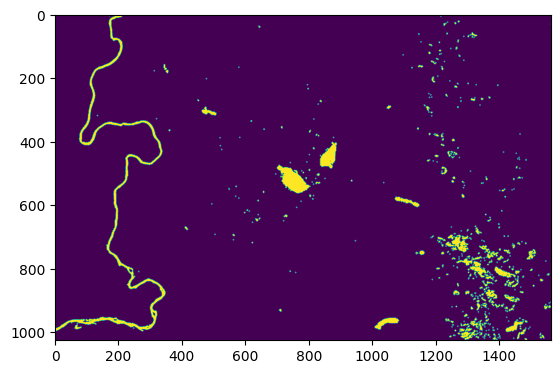

In [37]:
plt.imshow(water2)

---

**If we look at the difference between the new water mask, `water2`, and the old water mask `water`, we can see that we added a lot of new water pixels near existing water pixels.** This is what is meant by *focal dilation;* we *grow* existing water areas using a focal moving window.

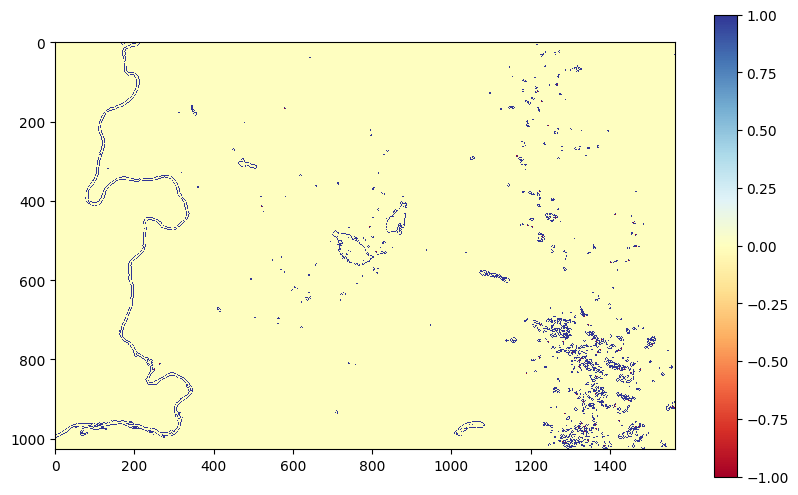

In [39]:
# Plot the areas where we added new water pixels in blue
cmap_diff = matplotlib.colormaps.get('RdYlBu')
plt.figure(figsize = (10, 6))
plt.imshow(water2 - water, cmap = cmap_diff, vmin = -1, vmax = 1, interpolation = 'nearest')
plt.colorbar()

The resulting water mask has a better representation of the Kicking Horse Reservoir, as it is now completely filled with water. However, we've added a lot of new water pixels in areas where there is probably no water; and, we've grown the overall size of any real water body, particularly the Flathead River.

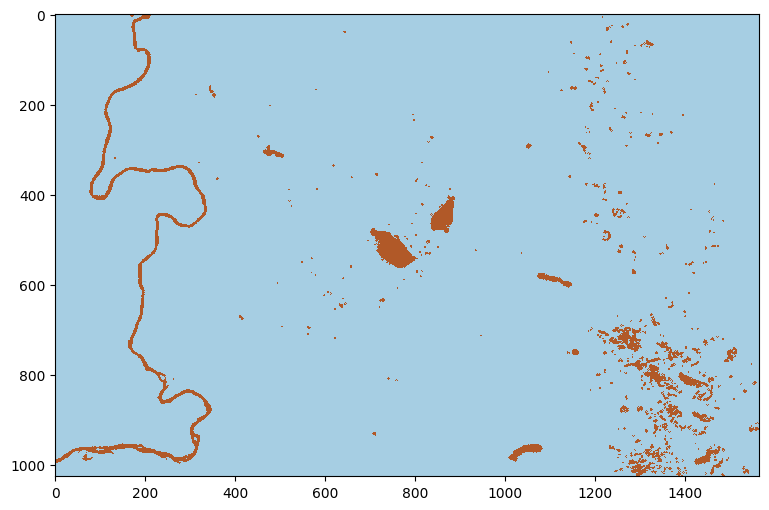

In [40]:
plt.figure(figsize = (10, 6))
plt.imshow(water2, cmap = cmap, interpolation = 'nearest')

**By combining focal dilation with focal erosion, we can get a good balance of improved shape representation without exaggerating the areas of water bodies.**

---

## Problem 6.4: Focal Erosion

Using `scipy.ndimage.generic_filter()` again but this time with the argument `footprint = block` (see below), apply a moving window filter to the `water2` array such that any windowed area with a minimum number of pixels $N$ should be classified as water (1), otherwise as non-water (0).

*It's up to you to choose the value of $N$;* compare results. Hint: As this is supposed to be a focal *erosion* process (i.e., shrinking or eliminating water areas), you want $N$ to be relatively high. But think about how high it should be based on the `footprint` below.

The resulting array should be assigned the variable name `water3`.

In [41]:
block = np.ones((5,5))
block[2,2] = 0 # Again, leave out the center pixel
block

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [47]:
# Make function to set threshhold of minimum number of 18 of 24 pixels required to classify the center as water
def many1there(window):
    if np.sum(window == 1) >= 21:
        return 1
    else:
        return 0

water3 = scipy.ndimage.generic_filter(water2, many1there, footprint = block)

---

Based on the value of $N$ I chose, I'm pretty happy with the result. Obviously, there's a lot that could be improved. We still have some spurious water pixels, particularly what are likely clouds, ice, or snow at the bottom-right of the image. But we could have masked these areas out in other ways, particularly by using the quality-assurance (QA) band from the original Landast image. The QA band reports which pixels of the image are likely to contain clouds, ice, or snow, based on a sophisticated algorithm.

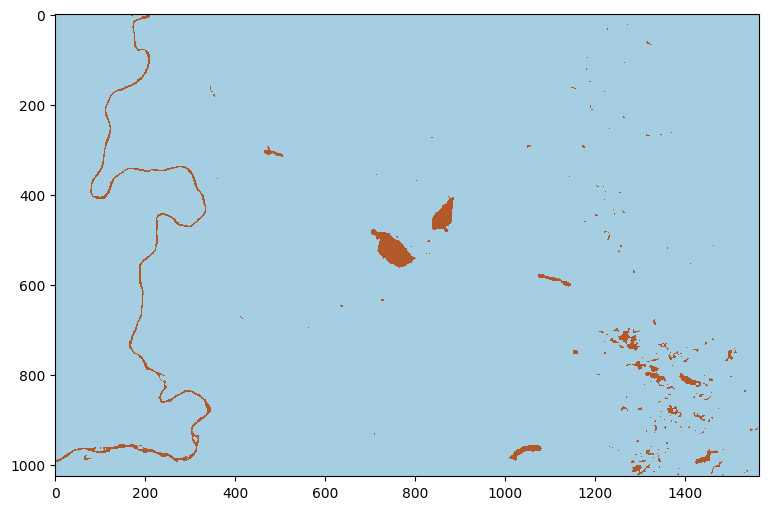

In [48]:
plt.figure(figsize = (10, 6))
plt.imshow(water3, cmap = cmap, interpolation = 'nearest')

---

## Problem 6.5: Putting it All Together

Apply what you learned in Problems 4.3 and 4.4 to *both* the 1999 and 2011 images (you've only done it for the 2011 so far). The resulting arrays should be named:

- 1999 water mask image: `water99`
- 2011 water mask image: `water11`

In [49]:
# Variables
# tm99_ndwi

water4 = np.where(tm99_ndwi[0] > 0, 1, 0)
water5 = scipy.ndimage.generic_filter(water4, any1there, footprint = cross) # Apply cross window
water6 = scipy.ndimage.generic_filter(water5, many1there, footprint = block) # Apply block window

# Save as new variable
water99 = water6.copy()
# This part's done!
water11 = water3.copy()

---

## Progress So Far...

**So far, we have two binary water masks, one for each year.** Next, we want to measure the area of the Kicking Horse Reservoir in each image.**

To make this easier, we'll crop our data one more time to zoom-in on the Kicking Horse Reservoir. Once we've done that, calculating lake area will be as simple as adding up all of the water pixels that make up the Reservoir.

## Optional Practice: Coordinate Transformations

**Earlier, we saw how we could use a Shapefile or other vector dataset to crop a raster image to an area of interest.**

Now, let's do the same thing a different way: Using a bounding box. We have the latitude-longitue coordinates for the area around the Kicking Horse Reservoir:

- Upper-left: 47.47887°N, -114.09684°W
- Lower-right: 47.44700°N, -114.05401°W

We'll need to:

1. Convert these latitude-longitude coordinates to match the projection of our raster data (Universal Transverse Mercator or UTM).
2. Transform the UTM coordinates (spatial coordinate system) to the image coordinate system, or rows and columns, using an affine transformation.

For Step 1, we'll use the `osr` module to define a `SpatialReference` system (SRS) for both the original SRS (latitude-longitude coordinates in the WGS84 datum) and the target SRS (UTM).

In [50]:
from osgeo import osr

wgs84 = osr.SpatialReference() # A blank SRS
wgs84.ImportFromEPSG(4326) # Look up the pre-defined SRS based on the EPSG code

print(wgs84.ExportToPrettyWkt())

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]


What's this about EPSG codes? Recall that you can always look these up at [epsg.io.](https://epsg.io/)

We can get the EPSG code for our `rasterio` raster by:

In [51]:
ds_tm99_nir.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Because we're learning programming, it's best if we can retrieve the information we need exactly; that is, let's get the EPSG code as an integer and not as text (as above).

In [35]:
ds_tm99_nir.crs.to_epsg()

32611

Now we can plug this into another blank `SpatialReference`. The function `ImportFromEPSG()` returns `0` because it is based on C code that uses a return value of `0` to indicate that "everything is okay."

In [54]:
utm = osr.SpatialReference()
utm

<osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x000001AA1201C8D0> >

In [53]:
utm = osr.SpatialReference()
utm.ImportFromEPSG(ds_tm99_nir.crs.to_epsg())

TypeError: in method 'SpatialReference_ImportFromEPSG', argument 2 of type 'int'

Finally, we're ready to define a coordinate transformation.

In [37]:
# A coordinate transformation from WGS84 (lat-long) to UTM
crs_transform = osr.CoordinateTransformation(wgs84, utm)
crs_transform.TransformPoint(47.47887, -114.09684)

(718726.6541086696, 5262467.285591335, 0.0)

For Step 2, we need to use an affine transformation to convert these UTM coordinates into row-column coordinates within the image. **Recall that since we cropped the original Landsat 5 scene, we need to use the affine transformation associated with the *cropped* image, not the original scene (the upper-left corner coordinate has changed).**

If you lost track of the affine transform from earlier, you can re-run the following, which will capture the affine transform as the variable named `transform` but the array itself will not be reproduced: `_` tells Python that it should not store the corresponding output in a variable.

In [38]:
_, transform = mask(ds_tm99_nir, [bbox], crop = True)

- Forward `transform`: Returns the spatial coordinates associated with the specified row-column coordinates
- Reverse `~transform`: Returns the row-column coordinates associated with the specified spatial coordinates

The reverse transform only works with integers, so we will need to convert these spatial coordinates (meters) to integers. The loss of (sub-meter) precision is acceptable because we're working with 30-meter pixels in the raster image. We also need to specify we want only the first two coordinates, because the `affine` transformation library can't handle 3-dimensional coordinates.

In [39]:
crs_transform.TransformPoint(47.47887, -114.09684)[0:2]

(718726.6541086696, 5262467.285591335)

In [40]:
~transform * np.array(crs_transform.TransformPoint(47.47887, -114.09684)[0:2]).astype(np.int32)

(800.0333333333328, 387.93333333334886)

Confusingly, the `affine` library returns the image coordinates in (column, row) order, probably because spatial coordiantes come in (horizontal coordinate, vertical coordiante) order. In practice, you'll want to verify a coordinate transformation pipeline when you first set it up: Do the transformed coordinates make sense for a known example?

In this example, the upper left-hand corner of our bounding box is at the row-column index: (387, 800). When we subset the image using this as the new top-left corner, we can see that the Kicking Horse Reservoir is nice and snug up in the top-left region of the image.

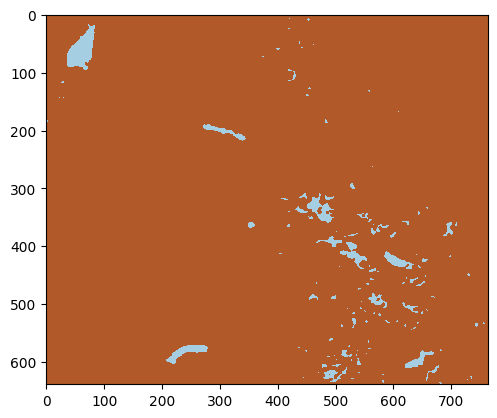

In [41]:
pyplot.imshow(water11[387:,800:], cmap = cmap, interpolation = 'nearest')

---

We could repeat the steps above to find the image coordinates of the lower right-hand corner, but it's easier to just guess them at this point!

In [ ]:
pyplot.imshow(water11[387:490,800:900], cmap = cmap, interpolation = 'nearest')

**Let's call these two smaller arrays `chip11` and `chip99` because we "chipped" them out of the bigger images.**

In [ ]:
chip11 = water11[387:490,800:900]
chip99 = water99[387:490,800:900]

---

## Calculating Lake Area

UTM is, strictly speaking, not an equal-area projection but each UTM "Zone" is chosen to minimize distortion and the error in distances and areas is quite small for most applications. So, we'll calculate areas directly based on pixel areas.

**Our water mask is made up of zeros and ones, therefore, `chip11.sum()` is the number of 30-meter water pixels. We can convert this number of 30-meter (square) pixels directly to area (in square kilometers):**

In [44]:
# Each pixel is 30-by-30 meters square; divide by 1000 meters-by-1000 meters square to get square kilometers
(chip11.sum() * (30 * 30)) / (1e3 * 1e3)

1.9656

In [45]:
(chip99.sum() * (30 * 30)) / (1e3 * 1e3)

0.6048

**So, if we assume 1999 and 2011 represent the driest and wettest years (respectively), we can see that the area of Kicking Horse Reservoir varies between 0.6 and 2.0 km$^2$.** You might get a slightly different answer depending on your focal erosion pixel threshold.

It'd be great if we could map these extent boundaries on top of the original NIR image. How can we convert these water masks into extent polygons? `rasterio` has limited support for converting contiguous regions of pixels into polygons.

## Converting Raster to Vector

The `rasterio` module has a sub-module called `features` that can be used to extract vector features from raster data. It's not the most advanced tool but it works pretty well for most simple thematic datasets like our water masks.

In [46]:
from rasterio import features

# Need to convert each array to 16-bit data or higher for use with features.shapes()
shapes99 = features.shapes(chip99.astype(np.int16), transform = transform)
shapes11 = features.shapes(chip11.astype(np.int16), transform = transform)

Note that the result of `features.shapes()` is a *generator;* recall that this is a place-holder for a potentially expensive operation (digitizing all the different contiguous pixel regions in an image).

In [47]:
shapes99

<generator object shapes at 0x7f0d3d5821f0>

Recall that we can force Python to execute that expensive operation on all the elements of the generator by converting the generator to a list.

In [48]:
shapes99 = list(shapes99)
shapes11 = list(shapes11)

We can see that we got back a series of GeoJSON features (polygons).

In [49]:
shapes11[0][0]

{'type': 'Polygon',
 'coordinates': [[(695145.0, 5273055.0),
   (695145.0, 5273025.0),
   (695175.0, 5273025.0),
   (695175.0, 5273055.0),
   (695145.0, 5273055.0)]]}

It's good that we zoomed into the Kicking Horse Reservoir, because we might have to sift through a lot of these features to find the right one! We 

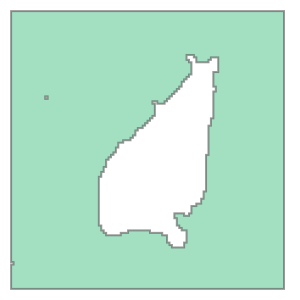

In [50]:
from shapely import geometry

geometry.shape(shapes11[-1][0])

Note that the library even includes all those pixels that make up the non-water area. The `features.shapes()` function doesn't know anyting about our data: it just sees a contiguous region of pixels with the same value (0) and connects them together.

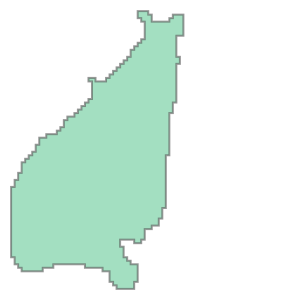

In [51]:
geometry.shape(shapes11[1][0])

There's the shape we want! Later, when we introduce the `fiona` library in class, we'll see how we might manipulate and ultimately export vector data like this lake boundary to a file.

## Writing the Water Mask Array to a Raster Dataset

**As a last example, let's review how we might take our water mask (a `numpy.ndarray`) and convert it to a GeoTIFF dataset.** Because we cropped our mask from the original Landsat image, we need to update the affine transformation (or GeoTransform) so that the resulting GeoTIFF image is displayed in the right place on the globe!

`transform` still refers to the *first* cropped image we created--the one that shows the Flathead River. We can get a familiar GDAL GeoTransform from this `affine.Affine` transform by:

In [52]:
gt = transform.to_gdal()
gt

(694725.0, 30.0, 0.0, 5274105.0, 0.0, -30.0)

We can use the upper-left corner that we retrieved earlier, when we cropped the image a second time, to update the GeoTransform to match the smaller image (our image "chips").

In [53]:
gt = list(gt) # Convert from tuple to list so we can change it
xmin, ymax = crs_transform.TransformPoint(47.47887, -114.09684)[0:2]
gt[0] = xmin
gt[3] = ymax
gt

[718726.6541086696, 30.0, 0.0, 5262467.285591335, 0.0, -30.0]

The `rasterio` library expects to work with `affine.Affine` objects, not GDAL GeoTransforms, so we need to convert back to an `affine.Affine` object before we create a new `rasterio` dataset.

In [54]:
from affine import Affine

height, width = chip11.shape

# Get the GeoTransform/ affine transformation as an Affine object
transform = Affine.from_gdal(*gt)

# CRS is the same regardless of whether we cropped the raster, so use the original
crs_utm = ds_tm11_nir.crs

dset2011 = rio.open(
    'KickingHorse2011.tif', 'w+', driver = 'GTiff', height = height, width = width, 
    count = 1, dtype = chip11.dtype, crs = crs_utm, transform = transform)

Then we write our water mask chip to the new dataset!

In [55]:
dset2011.write(chip11, 1)

Let's verify that it looks correct. You can also open the GeoTIFF file in QGIS.

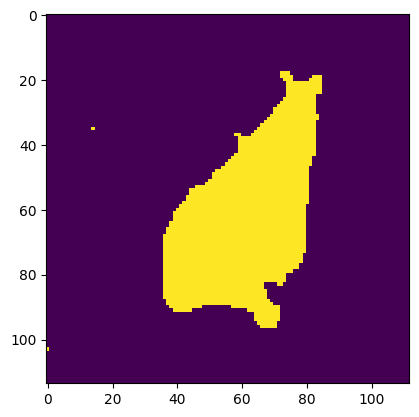

In [56]:
pyplot.imshow(dset2011.read(1), interpolation = 'nearest')